

**Neural ODEs for Lattice Field Theory**
---

Let us stare at this screenshot from Prof. Miranda Cheng's talk.
![picture](https://drive.google.com/uc?export=view&id=1CrbOMDeMZVTHcdFtGjeza6dVmEWZOGCg)
Suppose, we want to train a Neural Network perfectly, such that inputs are $x, y \in V_L$ on lattice, and outputs are $\phi_x \sim e^{- S[\phi]}$, sampled from a target lattice field theory, with action
$$S[\phi] = \sum\limits_{x,y \in V_L} \phi_x \Delta_{x,y} \phi_y + \sum\limits_{x \in V_L} (m^2 \phi_x^2 + \lambda \phi_x^4).$$

Such a perfectly trained Neural Network can be recast as an ODE
$$\frac{d}{dt}\phi(t)_x = v_{\theta}(\phi(t), t, \lambda)_x,$$
where ODE time $t \in \{0, \cdots , T \}$ corresponds to hidden layers. This ODE transforms Neural Network input $z:= z(0)$ to the desired output $\phi_x \sim e^{-S[\phi]}$.
* Here, $z:= z(0)$ are Lattice points $x,y \in V_L$.
* When the number of hidden layers is large, and training step size is infinitesimally small, all hidden layers post-training are represented by conitnuous function $v_{\theta}$, instead of usual convention of weights and biases.
* Such a perfectly trained Neural Network, which acts as a vector field between $z(0)$ and $z(T)$, is called a *Neural ODE*.

**From generic Neural Networks to Neural ODEs**
----

> [Reference paper](https://arxiv.org/pdf/1806.07366.pdf)
>
>A Neural ODE acts as a vector field between initial state $z(0)$ and target state $z(T)$.  
>
<!-- ![picture](https://drive.google.com/uc?export=view&id=1gI0Thz0PiGYfaH0M6a0aeO0zKAkZCu3v) -->
>

The following ODE
$$\frac{dz}{dt} = v_{\theta}(z,t),~~ z(0) = z,~~z(T)=\phi_x.$$
can be solved using Euler's method, where the ODE time is discretized into $n$ time-steps. The solution to this ODE, at any time step $t_{n+1}$, is
$$z_{n+1} = z_n + v_{\theta}(z_n, t_n) \cdot(t_{n+1} - t_n), $$
for $z_i := z(t_i).$

**We are interested in training a Neural Network to generate a Neural ODE *for any given problem.***
---
 To do that, we need some familiarity with ODE Solver functions inbuilt in python libraries commonly used to design Neural Networks.

 Let us introduce an ODE solver function called ```odeint``` from ```jax.experimental.ode``` Library.
----

This function
$$\text{odeint}(v_{\theta}, z_n, \text{array}(t_0, t_T), \theta_{t_n})$$

results in a tuple of the form (initial state $z_0$, target state $z_T$). In the context of Neural ODEs, $\theta_{t_n}$ are the network parameters of the $n^{\text{th}}$ hidden layer, and get updated via training.  


>Then, we need to define a loss function $L()$ that can be used to train a randomly initialized Network to produce a Neural ODE corresponding to a given problem. Consider the following loss function
$$L(\,z(t_{n+1})\,) = L \Big( \, z(t_n) + \int^{t_{n+1}}_{t_n} v_{\theta_{t_n}}(z_{t_n} , t_n , \theta_{t_n}) \, \Big) . $$
> The input to this loss function is an ODE solver of the form $\text{ODESolve}(z_{t_n}, v_{\theta_{t_n}}, t_n , t_{n+1})$.

**Example 0**
---

Consider initial state $z(0)=x$, and target state $z(T)=x^3 + 0.1x$. We want to construct a Neural ODE, starting from a simple fully connected feedforward Neural Network, using the loss function defined above. The trained Neural Network / the Neural ODE would correspond to a vector field $f: z(0) \to z(T)$.

Given below are the steps to get this Neural ODE. Some of these steps are left as exercises.
---

* First, we import necessary libraries.

In [ ]:
import jax.numpy as jnp
import numpy.random as nprand
from jax import grad, jit, vmap
from jax import random
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt

* Let us define the initial and final (target) states, $$z(0)=0, \\ z(T)=x^3 + 0.1x,$$ respectively.

In [ ]:
input = jnp.reshape(jnp.linspace(-2.5, 2.5, 15), (15, 1))
target = input**3 + 0.1 * input

* We want to draw initial Network parameters $\theta$ randomly, and update these through training. Given below is a function to draw parameters randomly.

In [ ]:
def init_random_params( N, rng=nprand.RandomState(0)): # N denotes the size or width of each hidden layer of the Neural ODE that we want
    return [(rng.randn(p, q), rng.randn(q))
            for p, q, in zip(N[:-1], N[1:])]

* Next, we want to define $f: z(0) \to z(T)$ as a fully connected feedforward Network. To do that, we define a function ```fcn``` that creates a fully connected feedforward Network from input ```xs``` and parameters $\theta$.

In [ ]:
def fcn(theta, xs):
    for w, b in theta:
      outputs = jnp.dot(xs, w) + b  # Linear transformation
      xs = jnp.tanh(outputs)        # Nonlinearity; we can choose ReLU or other nonlinearities as well
    return outputs

**Exercise 0: Define the function $v_{\theta_{t_n}}(z_{t_n}, t_n, \theta_{t_n})$.**
---


**Solution (to be removed before GitHub upload)**
---

In [ ]:
def v_theta(z_n, t_n, theta_t_n):
    f_arguments = jnp.hstack([z_n, jnp.array(t_n)])
    return fcn(theta_t_n, f_arguments)

**Exercise 1: Define the function $z_{t_{n+1}} = \text{ODESolve}(z_{t_n}, v_{\theta_{t_n}}, t_n , t_{n+1})$.**
---

**Solution (to be removed before GitHub upload)**
---

In [ ]:
def ODESolve(theta_t_n, z_n):
    t0_tT = jnp.array([0.0, 1.0]) # define a tuple of start and end times.
    z0, zT = odeint(v_theta, z_n, t0_tT, theta_t_n)
    return zT

**Exercise 2: Use function ODESolve to define a quadratic loss function. Call it ```NODE_L2loss```.**
---

Use the following tips.
* Function ```vmap``` can be used to apply function ODESolve to its inputs in a vectorized manner. E.g. ```batched_ODESolve = vmap(ODESolve, in_axes=(None, 0))```
* Function ```batched_ODESolve``` takes in two arguments: network parameters, and network input. Network output is ```batched_ODESolve(theta, xs)```.
* We define the quadratic loss as $L_2 = (z_{t_{n+1}} - z_T)^2$.

**Solution (to be removed before GitHub upload)**
----

In [ ]:
batched_ODESolve = vmap(ODESolve, in_axes=(None, 0))

In [ ]:
def NODE_L2loss(theta, xs, ys):
    f_x = batched_ODESolve(theta, xs)
    return jnp.mean(jnp.sum((f_x - ys)**2, axis=1))

**Next,**
---

* We define a simple gradient descent optimizer, using this loss. Let's call this loss function as ```NODE_L2loss```.

In [ ]:
def NODE_gd(theta, xs, ys):
    gradients = grad(NODE_L2loss)(theta, xs, ys)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(theta, gradients)]


* Next, using function ```init_random_params```, we initialize parameters $\theta$ for a fully connected feedforward Network (one that we intend to optimize enough to create a Neural ODE).

* This requires defining Network hyperparameters.

In [ ]:
NODE_width = [2, 20, 1] # layer sizes
step_size = 0.0005 # size of training steps
train_iters = 1000 # number of training steps

NODE_theta = init_random_params(NODE_width)

* Using these, we initialize the Network, and update it until Network input and output are $z(0)=x$ and $z(T) = x^3 + 0.1x$, respectively.



* Note that $T=2$; and layer sizes at $t=0,1,2$ are $N=2,20,1$, respectively.

In [ ]:
for i in range(train_iters):
    NODE_theta = NODE_gd(NODE_theta, input, target)

* This Neural Network is now a Neural ODE, representing a continuous transformation from inputs $z(0)$ to outputs $z(T)$.  

* Let us test the efficiency of this Neural ODE for a different choice of inputs.

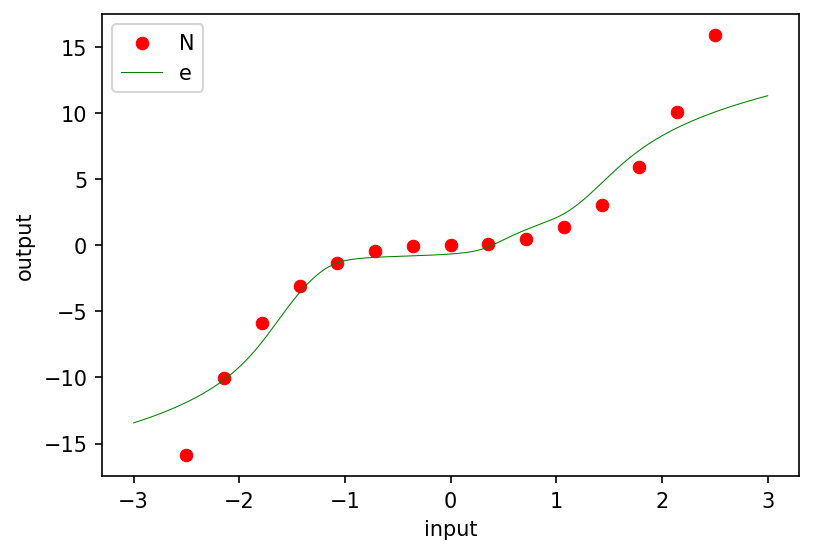

In [ ]:
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(input, target, lw=0.5, color='red')
new_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 300), (300, 1))
ax.plot(new_inputs, batched_ODESolve(NODE_theta, new_inputs), lw=0.5, color='green')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Neural ODE'))

**Example 1: Simple Harmonic Oscillator**
----

Consider the differential equation
$$m \, y''(t) + k\, y(t) =0,$$
for $m= 1.4$, $k=1.9$ (in appropriate units), and boundary conditions are
$$y(0)=1.2~,~ y(0.47)=0.09~,~y'(1)=0.$$

> The analytical solution (via Mathematica) is $$y(t) = 0.043576 \cos(1.16496 \, t) + 0.101414 \sin(1.16496 \, t)   .$$

We want to train a Neural Network such that its input and output after training are $t$ and $y(t)$, respectively. Such a trained Network would be a Neural ODE for this one-dimensional simple harmonic oscillator.

> To do so, we first note that, *any arbitrary ODE of order $n$* for some scalar function $y(t)$
$$G\big(y(t), y'(t), y''(t), \cdots , y^{(n)}(t),t \big) = 0,$$
can be mapped into **a system of first order ODEs**
$$y'_1(t) = y_2(t),\\
y'_2(t) = y_3(t), \\
\vdots \\
y'_n(t) = G^*\big(y(t), y'(t), y''(t), \cdots , y^{(n)}(t),t \big).
$$
Here, $G^*$ is obtained by solving $G$ for $y^{(n)}(t)$.

Our simple harmonic oscillator problem is a second order ODE. That can be recast as two joint first order ODEs. The trained Network, i.e. the Neural ODE, will produce a tuple made from $\big(y'(t), y(t) \big)$ as its output.  




Our goal here is to train a Neural Network to get this Neural ODE. This is broken into several steps. We will walk you through some of these steps, and leave some as exercises.
----

* First, we import necessary libraries.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

**Exercise 3: Define two functions $y(t)$ and $y'(t)$ for final (target) states of the Neural ODE.**
---

**Solution (to be removed before GitHub upload)**
---

In [ ]:
# harmonic oscillator solution y(t)
def y(t):
    return 0.043576*np.cos(1.16496*t) + 0.101414*np.sin(1.16496*t)
# first derivative of y(t)
def y_prime(t):
    return 0.118144*np.cos(1.16496*t) - 0.0507645*np.sin(1.16496*t)

**Next,**
---
* We generate Neural ODE initial state $t$ and final state $(y(t), y'(t))$ using functions ```y(t)``` and ```y'(t)```, defined above.

In [ ]:
input = np.random.rand(200)*30
target = np.array([y(input), y_prime(input)]).T # y and y_prime here are the functions for y(t) and y'(t), respectively.

* Then, we design a simple Neural Network with tanh activation function, each layer size 100, and use MSE loss and Adam optimizer to compile it.

In [ ]:
# define the model
ODE_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation=tf.nn.tanh, input_shape=(1,)),
    tf.keras.layers.Dense(100, activation=tf.nn.tanh),
    tf.keras.layers.Dense(2)
])
# compile it
ODE_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss=tf.keras.losses.MeanSquaredError()
)

* Now that we have initialized this network, we want to train this to get Neural ODE for the simple harmonic oscillator problem.

* First, learning is noisy, and we want to save the best parameters during training to use for future predictions. To do so, we define ```checkpoint``` below.

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("weights",
    save_weights_only=True, monitor="loss", verbose=1, save_best_only=True)

* Then train this model on input $t$ and target data $y(t), y'(t)$. We save the training history below.  

In [ ]:
history = ODE_model.fit(input, target, epochs=4500, batch_size=100,
    callbacks=[checkpoint])

Streaming output truncated to the last 5000 lines.
1/2 [==============>...............] - ETA: 0s - loss: 0.0029
Epoch 3154: loss did not improve from 0.00246
2/2 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 3155/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0028
Epoch 3155: loss did not improve from 0.00246
2/2 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 3156/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0036
Epoch 3156: loss did not improve from 0.00246
2/2 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 3157/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0024
Epoch 3157: loss did not improve from 0.00246
2/2 [==============================] - 0s 8ms/step - loss: 0.0028
Epoch 3158/4500
1/2 [==============>...............] - ETA: 0s - loss: 0.0032
Epoch 3158: loss did not improve from 0.00246
2/2 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 3159/4500

**Exercise 4: Plot the outputs (final states) of this Neural ODE, as well as the analytic solutions, for a new set of inputs given below.**
---
```x = np.linspace(0,30,1000)```

**Solution (to be removed before GitHub upload)**
----

In [ ]:
x = np.linspace(0,30,1000) # inputs
y = y(x) # analytic soluton for y(t)
y_prime = y_prime(x) # analytic solution for y'(t)

* Next, we load the saved weights of the Neural ODE and make predictions for new inputs.

In [ ]:
ODE_model.load_weights("weights")
new_y_prime = ODE_model.predict(x) # first axis is y(t), second axis is yprime(t)

32/32 [==============================] - 0s 2ms/step


* Then, we plot the predictions of this Neural ODE against analytic solutions of the harmonic oscillator.

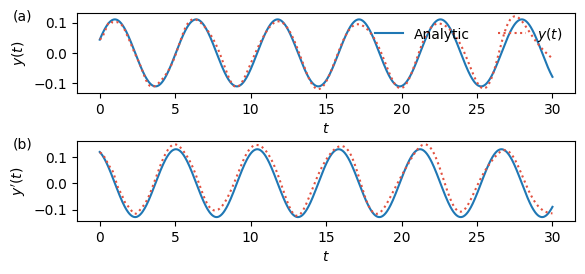

In [ ]:
fig = plt.figure(figsize=(6,4))
c1 = "#1F77B4"
c2 = "#E25140"
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, hspace=0.6)

ax = plt.subplot(3, 1, 1)
ax.annotate('(a)', xycoords="axes fraction", xy=(-0.13,0.9))
plt.xlabel("$t$")
plt.ylabel("$y(t)$")
plt.plot(x, y, color=c1, label="Analytic")
plt.plot(x, new_y_prime[:,0], color=c2, linestyle="dotted", label="$y(t)$")
plt.legend(loc='upper right', frameon=False, ncol=2)

ax = plt.subplot(3, 1, 2)
ax.annotate('(b)', xycoords="axes fraction", xy=(-0.13,0.9))
plt.xlabel("$t$")
plt.ylabel("$y'(t)$")
plt.plot(x, y_prime, color=c1, label="Analytic")
plt.plot(x, new_y_prime[:,1], color=c2, linestyle="dotted", label="$y''(t)$")

References
* https://arxiv.org/pdf/1806.07366.pdf
* https://lukasschwarz.de/deqnn#eq-oden
* https://docs.kidger.site/diffrax/examples/neural_ode/
* https://github.com/titu1994/tfdiffeq
